# Introduction 

This notebook is dedicated to implement some algorithms of the paper in those following situations :
    - Basic implementation for the basic image
    - Implementation in the situation of occlusion
    - Implementation in the situation of noisy image
    - Implementation for feature reduction
The goal of this notebook is to show the classification of ONE image in the previous situations. For the performance of the algorithms for all images please refer to the other notebook performance_on_yale.

To use this notebook you must choose at the beginning in which situation you wan't to be.

All the image comes from the dataset Extended Yale B (Cropped version)

All the data are in : data/CroppedYale/


# Imports 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time
import random

In [3]:
random.seed(2017) # For reproductibility

# Useful functions

The following function is the indicator function of the i-th class. For a given vector it returns just the index corresponding to the i-th class

In [4]:
def delta(x,i,classs):
    '''
    fonction indicatrice de la classe i
    '''
    n,m = len(x),len(classs)
    
    if (n != m):
        print('vectors of differents sizes, cannot operate delta')
        
    tmp = i*np.ones(n)-classs

    for k in range(n):
        if tmp[k]==0:
            tmp[k]=1
        else:
            tmp[k]=0 
            
    return tmp*x

The residu function returns the class which minimizes the reconstruction error following the norm 2

In [5]:
def residu(y,A,x,class_x):
    '''
    renvoie les residus pour chaque classe.
    '''
    k = np.max(class_x)+1
    r = np.zeros(k)
    
    for i in range(0,k):
        r[i] = np.linalg.norm(y - np.dot(A,delta(x,i,class_x)))
        
    return r

Définition de la fonction retournant l'indice de concentration (_Sparsity Concentration Index_)

The SCI function implements the Sparsity Concentration Index (with $k$ number of classes and $\delta_{i}$ the indicator of i-th class)  :

$$SCI(x)=\frac{k*max_i  \frac{\|\delta_{i}(x)\|_{1}}{\|x\|_{1}}-1}{k-1}$$

It is used to filter out the bad images.

In [6]:
def SCI(x,classs):
    '''
    @input
      - classs: classe de chaque training element.
      - x     : sparse coefficients
    '''
    
    k = len(set(classs)) # Nombre de classes différentes
    
    # Puis on retourne la valeur du SCI
    return (k*(1/np.linalg.norm(x,ord=1))*np.max([np.linalg.norm(delta(x,i,classs),ord=1) for i in range(k)]) - 1)/(k-1)
    

**Utilitaire** : trouver la classe d'un élément du test set pour le Yale Database

In [7]:
def find_class(i):
    return int(i)/12

**Utilitaire** : The following function is dedicated to read all the images given a path to a database

In [8]:
def read_images(path, sz=None,sz0=168,sz1=192): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given) and check that it's the good size
                    if ((im.size[0] == sz0) & (im.size[1]==sz1)):
                        if (sz is not None):
                            im = im.resize(sz, Image.NEAREST)     
                        X.append(np.asarray(im, dtype=np.uint8)) 
                        y.append(c)
                except IOError:
                    pass
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
            
    print("Images chargees !")
    return [X,y]

The following function add noise to an image. Given a amount of pixel to corrupt, it replace the pixel with a random pixel between 0 and 256.

# Upload images : choose the feature reduction

** Chose the feature reduction **

You can choose those following feature reduction :

* reduced_fs_dimension : réduction de dimension classique
* fisherfaces
* eigenfaces
* randomfaces

In [9]:
mode_reduc_features = 'randomfaces'
size_features = (12,10) # Egalement utilisé plus bas !
path_images = 'data/CroppedYale/' # On détermine ici sur quelles images on veut s'entrainer

n_components = size_features[0]*size_features[1]

print("Réduction de features choisie : ", mode_reduc_features)

('R\xc3\xa9duction de features choisie : ', 'randomfaces')


** Upload images **

In [10]:
# D'abord on charge les images originales (utilisées pour la visualisation et la reconstruction)

X_original, y_original = read_images(path_images, sz=None)

# Ensuite on charge les images sur lesquelles on va travailler tout au long du notebook

if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=None)
else :
    X, y = read_images(path_images, sz=(12,10))

Images chargees !
Images chargees !


In [11]:
print("Nombre d'éléments chargés ",len(X))

("Nombre d'\xc3\xa9l\xc3\xa9ments charg\xc3\xa9s ", 2432)


## Separation train/test

Each person has 64 images sotcked in _X_new_ :

* 29 images "négatives" (ex : yaleB01_P00A**-**005E-10)
* 35 images "positives" (ex : yaleB01_P00A**+**050E-40)

_NB :_ A lot of images are quite illisible (bad luminosity)

In order to have a test and train set qui homogenous , we'll take 12 test images and 52 for the train, so :
* 5 images "négatives"
* 7 images "positives"


In [12]:
X_train, X_test = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(35,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)
    else:
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)

## Matrix manipulation

On déroule chaque image en un vecteur puis on les concatène.

In [13]:
X_toconcat_train = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_test]

# Puis concaténation pour avoir une matrice unique
Xtrain = np.concatenate(X_toconcat_train,axis=1) # Liste des samples du train, concaténés en colonne.
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

print Xtrain[:,0]

[ 80 111 130 148 177 151 148 155 158 148 121  97  66 115 118 154 178 201
 186 178 161 114  79  57 109 110  92  86  86 104 170  89  80  83  78 103
 135 104 114 124 125  68 106  93 118 113 115 100 124 136 151 152 107  97
 106  65 129 163 161 142 106 129 151 168  88  88 137 121 135 165 136 124
  89 136 160 171 112 100 139  97 135 180 154  91  89 130 113 113 101 121
 135 120  98 105 142 114  59  85 105  98  68 104 108  91  57 135 122  91
  42  71  95 113 124 110 105 128 117 116 114  75]


## Feature reduction

La réduction de dimensions peut déjà être inclue dans le chargement des images si l'on fait juste de la réduction de dimension basique. Mais on peut également choisir une méthode plus évoluée !

_ Ne pas oublier de renseigner la variable **size_features** plus haut _

For more details for feature reduction see **features_reduction.py**

In [14]:
from features_reduction import *

Normalisation

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.fit_transform(Xtest)
print Xtrain[:,0]

[-1.19895168 -0.20671581  0.40142876  0.97756572  1.90578637  1.07358854
  0.97756572  1.20161898  1.29764181  0.97756572  0.11336028 -0.65482233
 -1.6470582  -0.07868537  0.01733745  1.16961137  1.93779398  2.67396898
  2.19385485  1.93779398  1.39366463 -0.11069298 -1.23095929 -1.93512668
 -0.27073102 -0.23872342 -0.81486037 -1.00690603 -1.00690603 -0.43076907
  1.68173311 -0.9108832  -1.19895168 -1.10292885 -1.2629669  -0.46277668
  0.5614668  -0.43076907 -0.11069298  0.20938311  0.24139072 -1.58304298
 -0.36675385 -0.78285276  0.01733745 -0.14270059 -0.07868537 -0.5587995
  0.20938311  0.59347441  1.07358854  1.10559615 -0.33474624 -0.65482233
 -0.36675385 -1.67906581  0.36942115  1.45767985  1.39366463  0.78552006
 -0.36675385  0.36942115  1.07358854  1.61771789 -0.94289081 -0.94289081
  0.62548202  0.11336028  0.5614668   1.52169507  0.59347441  0.20938311
 -0.9108832   0.59347441  1.36165702  1.71374072 -0.1747082  -0.5587995
  0.68949724 -0.65482233  0.5614668   2.0018092   1.1

/Users/maxwab/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [16]:
if (mode_reduc_features == 'eigenfaces'):
    Xtrain, Xtest = eigenfaces(Xtrain.T,Xtest.T,n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
elif (mode_reduc_features == 'fisherfaces'):
    Xtrain, Xtest = fisherfaces(Xtrain.T,ytrain,Xtest.T,n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
elif (mode_reduc_features == 'randomfaces'):
    Xtrain, Xtest = randomfaces(Xtrain.T, Xtest.T, n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
    
# Note : on n'oublie pas de transposer pour pouvoir utiliser les fonctions de features_reduction

Random projection done in 0.008s


In [17]:
print Xtrain[0]

[-0.33886307 -0.65038868 -0.32413622 ..., -1.64097905  0.29384227
 -0.93968953]


In [18]:
print('Taille du nouveau dataset',Xtest.shape)

('Taille du nouveau dataset', (120, 456))


# Algorithm 1 implementation of basic classification (no noise/occlusion)


Here we implement the algorithm 1 of the paper (relaxed version)
	
- Input : a matrix of training samples $A=\lbrack A_{1},A_{2},...,A_{k} \rbrack \in \mathbb{R}^{m \times n}$ for k classes and a test sample $y \in \mathbb{R}^{m}$
- Normalize the columns of A to have unit $L^{2}$ norm
- Solve the $L^{1}$ minimization problem : $\hat{x_{1}}= argmin \|x\|_{1}$   sc  $\|Ax-y\|_{2} \leq \epsilon$		
- Compute the residuals
	$ \mbox{ for all } i=1,...k, r_{i}(y)=\|y-A\delta_{i}(\hat{x_{1}})\|_{2}$
	
- $\mathcal{C}_{y}=argmin_{i} r_{i}(y)$
	

In [19]:
from sklearn.linear_model import Lasso

We have seen in the that the minimization problem is equivalent to the LASSO problem.

First we create a vector of d'$\alpha_i$ to test with LASSO.
We have to adapt our $\alpha_i$ to the dimension of $y$

In [20]:
alpha_vec = np.logspace(2,4,20)
alpha_vec = alpha_vec/(Xtest.shape[0])

Then we apply LASSO to our problem.

# Choose your example

Here you can choose the face you wan't to test from 0 to 456 with the testval

In [21]:
#for i, alpha in enumerate(alpha_vec):

testval = 300 # Id : élément du test set à évaluer grâce à notre algorithme.

clf = Lasso(alpha=0.02) #on prend l'alpha courant

# Standard : on choisit y parmi l'ensemble de test
y = Xtest[:,testval]

clf.fit(Xtrain,y)
x = clf.coef_

** Affichage des résultats **

In [22]:
pred_class = np.argmin(residu(Xtest[:,testval],Xtrain,x,ytrain))

In [23]:
print("Classe réelle: ", ytest[testval])
print("Classe prédite: ", pred_class)
print("Rejection: ", SCI(x,ytrain))

('Classe r\xc3\xa9elle: ', 25)
('Classe pr\xc3\xa9dite: ', 25)
('Rejection: ', 0.98397406812209487)


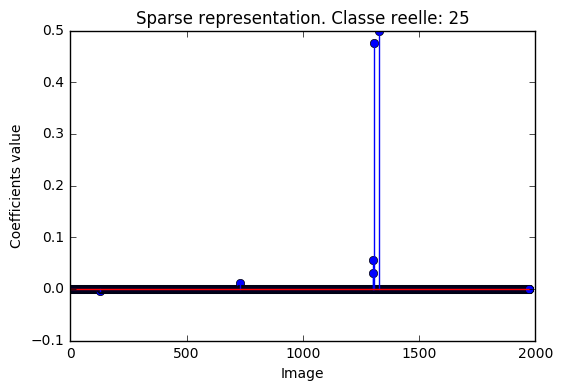

In [24]:
plt.figure()
plt.stem(x)
plt.title('Sparse representation. Classe reelle: ' + str(ytest[testval]))
plt.ylabel('Coefficients value')
plt.xlabel('Image')

We see that the solution is really really sparse, that's work !

### Residuals

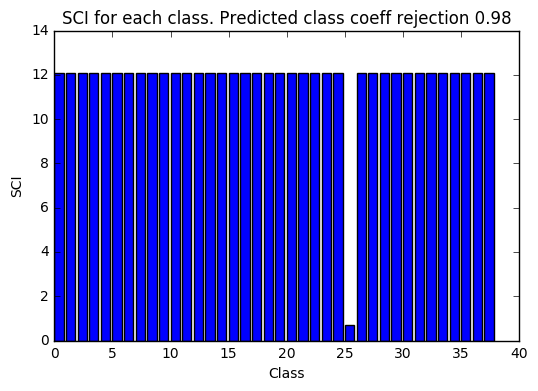

In [25]:
plt.figure()
plt.clf()
plt.bar(range(38),residu(Xtest[:,testval],Xtrain,x,ytrain))
plt.title('SCI for each class. Predicted class coeff rejection ' + str(np.round(SCI(x,ytrain),2)))
plt.ylabel('SCI')
plt.xlabel('Class')

As well the SCI makes a very clear difference between all the classes

### Image reconstruction

Here we get the original images and the coeff of selected image with the sparse representation and we reconstruct our image 

** Original **

In [26]:
i_original = indices_test[testval] #L'indice de la photo dans le dataset de départ non séparé

try:
    X_toconcat_original = [np.reshape(e,(X_original[0].shape[0]*X_original[0].shape[1],1)) for i,e in enumerate(X_original)]
except:
    print(e.shape)
    plt.imshow(X_original[i], cmap='gray')

# Puis concaténation pour avoir une matrice unique
Xoriginal = np.concatenate(X_toconcat_original,axis=1) # Liste des samples du train, concaténés en colonne.

** Error on image **

In [27]:
erreur_recomposition = np.reshape(np.dot(Xoriginal[:,indices_train],x),(X_original[i_original].shape[0],X_original[i_original].shape[1]))    

** Print recomposed image with just the predicted class **

In [28]:
# On recompose l'image en utilisant seulement les composantes du vecteur x liées à la classe prédite.
face_recomposee = np.reshape(np.dot(Xoriginal[:,indices_train],delta(x,pred_class,ytrain)),(X_original[i_original].shape[0],X_original[i_original].shape[1]))

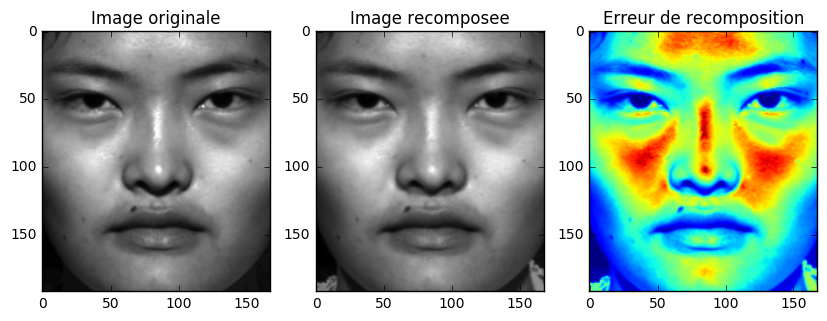

In [29]:
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[i_original], cmap='gray')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(face_recomposee, cmap='gray')
plt.title('Image recomposee')
plt.subplot(1,3,3)
plt.imshow(erreur_recomposition)
plt.title('Erreur de recomposition')

# Algorithm 1 implementation of classification with noise

Here we will add noise to our test image and see if the classification is good or not

In [30]:
def noise_image(image_input, per=0.5):
    '''
    Ajoute du bruit aléatoire à une image.
    @params:
        per : pourcentage de pixels à corrompre
    '''
    sz0 = image_input.shape[0]
    sz1 = image_input.shape[1]
    
    # Création du masque
    nb_pix_to_noise = int(np.floor(per*sz0*sz1))
    
    mask = np.ones((sz0*sz1,1))
    ids = np.random.permutation(sz0*sz1)[0:nb_pix_to_noise]
    mask[ids] = 0
    mask = np.reshape(mask,(sz0,sz1))
    
    # Matrice de pixels aléatoires (intensité entre 0 et 255)
    rand_pix = np.random.randint(0,256,size=(sz0,sz1))
    
    # On retourne la matrice initiale où l'on a changé les pixels indiqués par des pixels aléatoires
    return np.multiply(mask,image_input) + np.multiply(1-mask,rand_pix)
    

### Build the dataset

In [31]:
testval = 12

In [32]:
X_train, X_test = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(35,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X_original[i])
        ytest.append(y_original[i])
        indices_test.append(i)
    else:
        X_train.append(X_original[i])
        ytrain.append(y_original[i])
        indices_train.append(i)

In [33]:
X_test_bf = []
X_train_sz = []
noise=0.3
for i in range(len(X_test)):
    tmp = noise_image(X_test[i],noise)
    im = Image.fromarray(tmp)
    im = im.resize([96,84], Image.NEAREST)     
    X_test_bf.append(np.asarray(im, dtype=np.uint8))
        
        
for i in range(len(X_train)):
    im = Image.fromarray(X_train[i])
    im = im.resize([96,84], Image.NEAREST)     
    X_train_sz.append(np.asarray(im, dtype=np.uint8))
        
X_train = X_train_sz

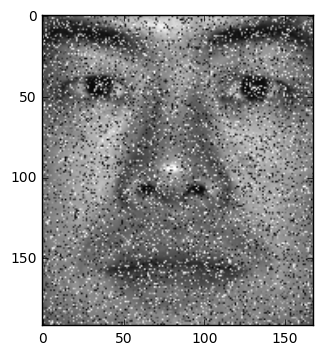

In [34]:
tmp = noise_image(X_test[testval],noise)
plt.imshow(tmp,cmap='gray')
im = Image.fromarray(tmp)
im = im.resize((96,84), Image.NEAREST)

In [35]:
########### Manipulation des matrices
X_toconcat_train = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_test_bf]

# Puis concaténation pour avoir une matrice unique
Xtrain = np.concatenate(X_toconcat_train,axis=1) # Liste des samples du train, concaténés en colonne.
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

### Fit

In [36]:
########### Normalisation
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.fit_transform(Xtest)

Xtrain2 = np.concatenate([Xtrain,np.eye(X_train[0].shape[0]*X_train[0].shape[1])],axis=1)

In [37]:
# Standard : on choisit y parmi l'ensemble de test
y = Xtest[:,testval]

In [38]:
clf = Lasso(alpha=0.02)

clf.fit(Xtrain2,y)
x = clf.coef_
pred_class = np.argmin(residu(Xtest[:,testval],Xtrain,x[:len(ytrain)],ytrain))

In [39]:
np.sum(x[len(ytrain):]>0)

0

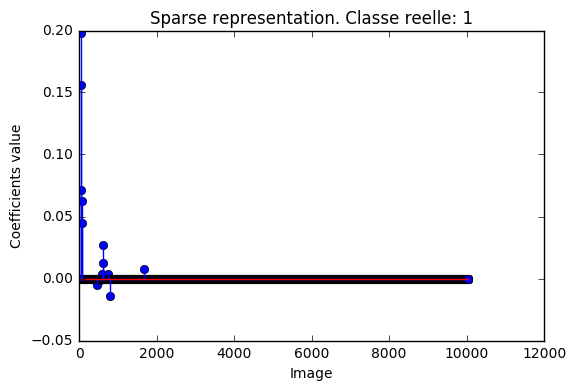

In [40]:
plt.figure()
plt.stem(x)
plt.title('Sparse representation. Classe reelle: ' + str(ytest[testval]))
plt.ylabel('Coefficients value')
plt.xlabel('Image')

The sparse representation is not as clear as the one without noise and it is pretty logic. 

On reste très proche de la représentation idéale mais on voit que les coefficients de la partie représentant l'erreur ne sont pas utilisés, ce qui est étrange !

### Residuals

In [41]:
print("Classe réelle: ", ytest[testval])
print("Classe prédite: ", pred_class)
print("Rejection: ", SCI(x[:len(ytrain)],ytrain))

('Classe r\xc3\xa9elle: ', 1)
('Classe pr\xc3\xa9dite: ', 1)
('Rejection: ', 0.87462879788673131)


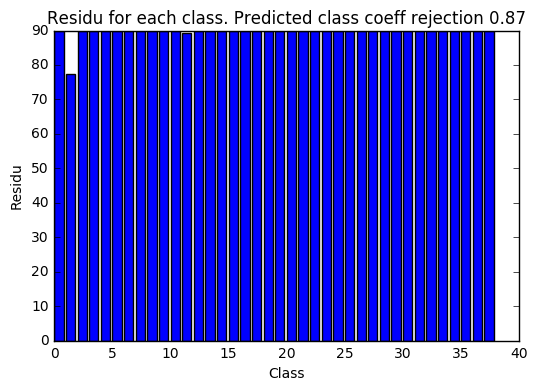

In [42]:
plt.figure()
plt.clf()
plt.bar(range(38),residu(Xtest[:,testval],Xtrain,x[:len(ytrain)],ytrain))
plt.title('Residu for each class. Predicted class coeff rejection ' + str(np.round(SCI(x[:len(ytrain)],ytrain),2)))
plt.ylabel('Residu')
plt.xlabel('Class')

As well for the residuals it is not as good as the previous example, we do not see a clear difference between the SCI.

In [43]:
i_original = indices_test[testval] #L'indice de la photo dans le dataset de départ non séparé

try:
    X_toconcat_original = [np.reshape(e,(X_original[0].shape[0]*X_original[0].shape[1],1)) for i,e in enumerate(X_original)]
except:
    print(e.shape)
    plt.imshow(X_original[i], cmap='gray')

# Puis concaténation pour avoir une matrice unique
Xoriginal = np.concatenate(X_toconcat_original,axis=1) # Liste des samples du train, concaténés en colonne.

In [44]:
erreur_recomposition = np.reshape(np.dot(Xoriginal[:,indices_train],x[:len(ytrain)]),(X_original[i_original].shape[0],X_original[i_original].shape[1]))    

In [45]:
face_recomposee = np.reshape(np.dot(Xoriginal[:,indices_train],delta(x[:len(ytrain)],pred_class,ytrain)),(X_original[i_original].shape[0],X_original[i_original].shape[1]))

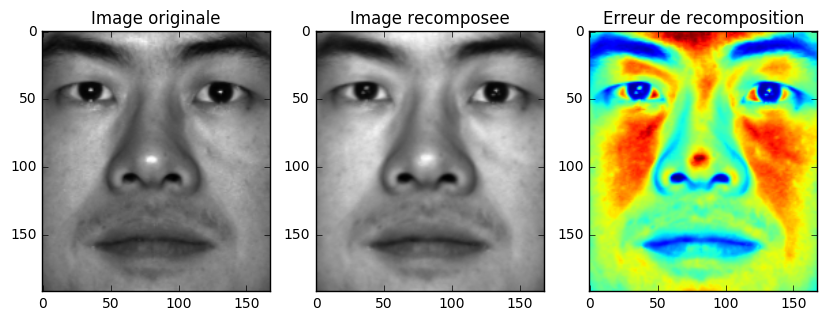

In [46]:
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[i_original], cmap='gray')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(face_recomposee, cmap='gray')
plt.title('Image recomposee')
plt.subplot(1,3,3)
plt.imshow(erreur_recomposition)
plt.title('Erreur de recomposition')

# Algorithm 1 implementation of classification with occlusion

Here we will add occlusion to our test image and see if the classification is good or not. The following function creates a black box in the image. You can choose the black box corner with x0, x1 ...

In [47]:
testval=300

In [48]:
def black_frame(array_orig, x0, x1, y0, y1):
    '''
    Ajoute un bandeau noir dont les coins sont de coordonnées (x0,y0),(x1,y1),(x0,y1) et (x1,y0)
    '''
    array_tmp = np.ones_like(array_orig)
    
    if ((x0 > array_tmp.shape[1]) | (x1 > array_tmp.shape[1]) | (y0 > array_tmp.shape[0]) | (y1 > array_tmp.shape[0])):
        print("Error : coordonnees du bandeau trop grandes pour l'image")
    
    for i in range(array_tmp.shape[1]):
        for j in range(array_tmp.shape[0]):
            if ((i >= min(x0,x1)) & (i <= max(x0,x1)) & (j >= min(y0,y1)) & (j <= max(y0,y1))):
                array_tmp[j][i] = 0
    
    return array_tmp*array_orig

### Build the dataset

We now build the dataset with occluded images for the test

In [49]:
X_train, X_test = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(35,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X_original[i])
        ytest.append(y_original[i])
        indices_test.append(i)
    else:
        X_train.append(X_original[i])
        ytrain.append(y_original[i])
        indices_train.append(i)

In [50]:
X_test_bf = []
X_train_sz = []
for i in range(len(X_test)):
    tmp = black_frame(X_test[i],10,153,39,69)
    im = Image.fromarray(tmp)
    im = im.resize([96,84], Image.NEAREST)     
    X_test_bf.append(np.asarray(im, dtype=np.uint8))
        
        
for i in range(len(X_train)):
    im = Image.fromarray(X_train[i])
    im = im.resize([96,84], Image.NEAREST)     
    X_train_sz.append(np.asarray(im, dtype=np.uint8))
        
X_train = X_train_sz

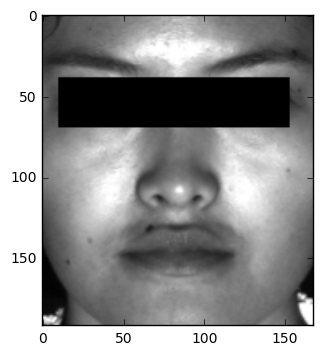

In [51]:
tmp = black_frame(X_test[testval],10,152,39,69)
plt.imshow(tmp,cmap='gray')
im = Image.fromarray(tmp)
im = im.resize((96,84), Image.NEAREST)

In [52]:
########### Manipulation des matrices
X_toconcat_train = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_test_bf]

# Puis concaténation pour avoir une matrice unique
Xtrain = np.concatenate(X_toconcat_train,axis=1) # Liste des samples du train, concaténés en colonne.
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

### Fit

We take the same example image 

In [53]:
########### Normalisation
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.fit_transform(Xtest)

Xtrain2 = np.concatenate([Xtrain,np.eye(X_train[0].shape[0]*X_train[0].shape[1])],axis=1)

In [54]:
# Standard : on choisit y parmi l'ensemble de test
y = Xtest[:,testval]
clf = Lasso(alpha=0.2) #on prend l'alpha courant

clf.fit(Xtrain2,y)
x = clf.coef_
pred_class = np.argmin(residu(Xtest[:,testval],Xtrain,x[:len(ytrain)],ytrain))

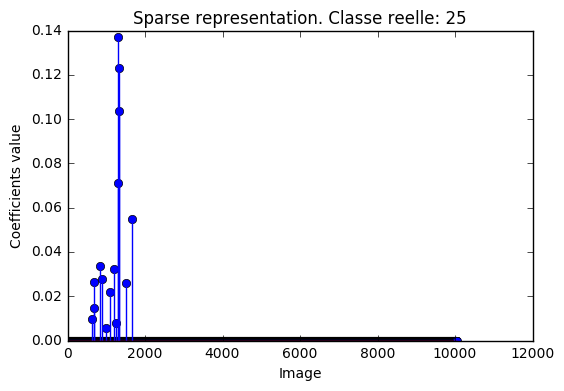

In [55]:
plt.figure()
plt.stem(x)
plt.title('Sparse representation. Classe reelle: ' + str(ytest[testval]))
plt.ylabel('Coefficients value')
plt.xlabel('Image')

The sparsity is worse than the case with no occlusion, but still in the good space of images.

In [56]:
print("Classe réelle: ", ytest[testval])
print("Classe prédite: ", pred_class)
print("Rejection: ", SCI(x[:len(ytrain)],ytrain))

('Classe r\xc3\xa9elle: ', 25)
('Classe pr\xc3\xa9dite: ', 25)
('Rejection: ', 0.61508918925476019)


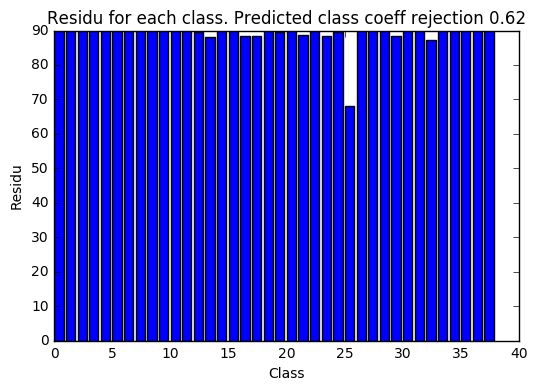

In [57]:
plt.figure()
plt.clf()
plt.bar(range(38),residu(Xtest[:,testval],Xtrain,x[:len(ytrain)],ytrain))
plt.title('Residu for each class. Predicted class coeff rejection ' + str(np.round(SCI(x[:len(ytrain)],ytrain),2)))
plt.ylabel('Residu')
plt.xlabel('Class')

We see that our rejection coefficient is higher than in the situation of no occlusion, but the predicted class is still the same : the sparisty worked.

In [58]:
i_original = indices_test[testval] #L'indice de la photo dans le dataset de départ non séparé

try:
    X_toconcat_original = [np.reshape(e,(X_original[0].shape[0]*X_original[0].shape[1],1)) for i,e in enumerate(X_original)]
except:
    print(e.shape)
    plt.imshow(X_original[i], cmap='gray')

# Puis concaténation pour avoir une matrice unique
Xoriginal = np.concatenate(X_toconcat_original,axis=1) # Liste des samples du train, concaténés en colonne.

In [59]:
erreur_recomposition = np.reshape(np.dot(Xoriginal[:,indices_train],x[:len(ytrain)]),(X_original[i_original].shape[0],X_original[i_original].shape[1]))    

In [60]:
face_recomposee = np.reshape(np.dot(Xoriginal[:,indices_train],delta(x[:len(ytrain)],pred_class,ytrain)),(X_original[i_original].shape[0],X_original[i_original].shape[1]))

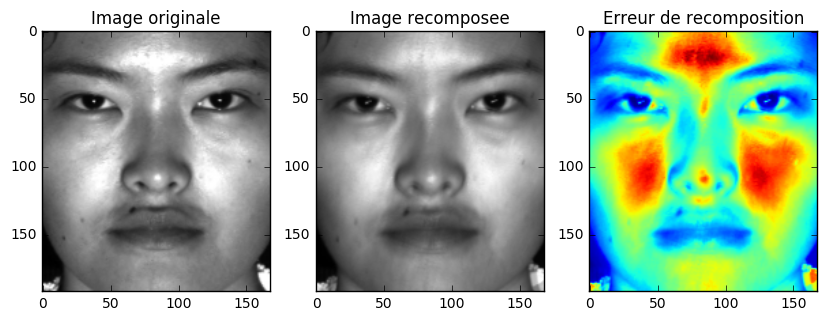

In [61]:
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[i_original], cmap='gray')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(face_recomposee, cmap='gray')
plt.title('Image recomposee')
plt.subplot(1,3,3)
plt.imshow(erreur_recomposition)
plt.title('Erreur de recomposition')

As well, the recomposition is worse than the case of no occlusion, but we clearly see the same face.

# Algorithm 1 implementation of basic classification, test with bad test image


Here we implement the algorithm 1 of the paper (relaxed version)
	
- Input : a matrix of training samples $A=\lbrack A_{1},A_{2},...,A_{k} \rbrack \in \mathbb{R}^{m \times n}$ for k classes and a test sample $y \in \mathbb{R}^{m}$
- Normalize the columns of A to have unit $L^{2}$ norm
- Solve the $L^{1}$ minimization problem : $\hat{x_{1}}= argmin \|x\|_{1}$   sc  $\|Ax-y\|_{2} \leq \epsilon$		
- Compute the residuals
	$ \mbox{ for all } i=1,...k, r_{i}(y)=\|y-A\delta_{i}(\hat{x_{1}})\|_{2}$
	
- $\mathcal{C}_{y}=argmin_{i} r_{i}(y)$
	

In [62]:
from sklearn.linear_model import Lasso

We have seen in the that the minimization problem is equivalent to the LASSO problem.

First we create a vector of d'$\alpha_i$ to test with LASSO.
We have to adapt our $\alpha_i$ to the dimension of $y$

In [63]:
alpha_vec = np.logspace(2,4,20)
alpha_vec = alpha_vec/(Xtest.shape[0])

Then we apply LASSO to our problem.

# Choose your example

Here you can choose the face you wan't to test from 0 to 456 with the testval

Chargement test image

In [64]:
im = Image.open(os.path.join('data_test' , 'test0.jpeg')) 
im = im.convert("L")
# resize to given size (if given) and check that it's the good size
im = im.resize((96,84), Image.NEAREST)     
X_bad = np.asarray(im, dtype=np.uint8)


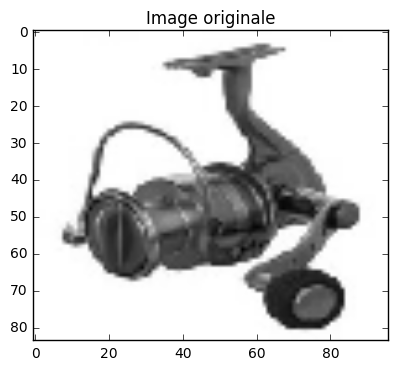

In [65]:
plt.figure()
plt.clf()
plt.imshow(X_bad, cmap='gray')
plt.title('Image originale')

In [68]:
#for i, alpha in enumerate(alpha_vec):

clf = Lasso(alpha=0.02) #on prend l'alpha courant

# Standard : on choisit y parmi l'ensemble de test
y = np.reshape(X_bad,(96*84,1))

clf.fit(Xtrain,y)
x = clf.coef_

/Users/maxwab/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** Affichage des résultats **

In [69]:
pred_class = np.argmin(residu(Xtest[:,testval],Xtrain,x,ytrain))

In [70]:
print("Classe réelle: ", ytest[testval])
print("Classe prédite: ", pred_class)
print("Rejection: ", SCI(x,ytrain))

('Classe r\xc3\xa9elle: ', 25)
('Classe pr\xc3\xa9dite: ', 25)
('Rejection: ', 0.021101786560307992)


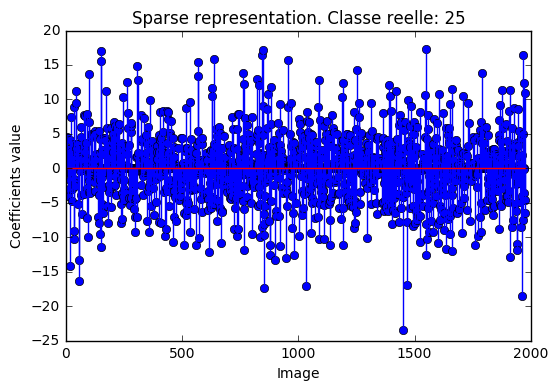

In [71]:
plt.figure()
plt.stem(x)
plt.title('Sparse representation. Classe reelle: ' + str(ytest[testval]))
plt.ylabel('Coefficients value')
plt.xlabel('Image')

On voit bien que pour une image aléatoire les coefficients sont très répartis : la SCI est de 0.02 !

Cela confirme qu'on peut utiliser a priori la fonction SCI pour faire une réjection de certaines images quin 'auraient rien à voir, sachant qu'on avait une SCI assez élevée pour les exemples bien classés ci-dessus.

### Residuals

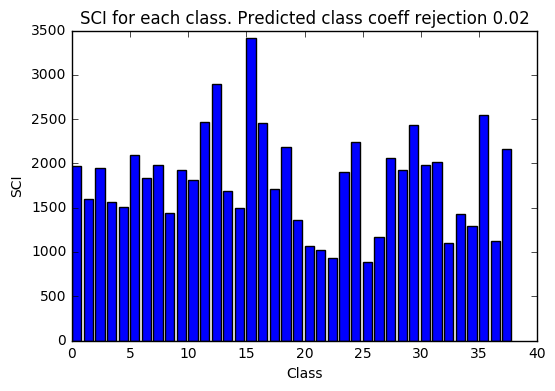

In [72]:
plt.figure()
plt.clf()
plt.bar(range(38),residu(Xtest[:,testval],Xtrain,x,ytrain))
plt.title('SCI for each class. Predicted class coeff rejection ' + str(np.round(SCI(x,ytrain),2)))
plt.ylabel('SCI')
plt.xlabel('Class')

As well the SCI makes a very clear difference between all the classes

### Image reconstruction

Here we get the original images and the coeff of selected image with the sparse representation and we reconstruct our image 

** Original **

In [73]:
i_original = indices_test[testval] #L'indice de la photo dans le dataset de départ non séparé

try:
    X_toconcat_original = [np.reshape(e,(X_original[0].shape[0]*X_original[0].shape[1],1)) for i,e in enumerate(X_original)]
except:
    print(e.shape)
    plt.imshow(X_original[i], cmap='gray')

# Puis concaténation pour avoir une matrice unique
Xoriginal = np.concatenate(X_toconcat_original,axis=1) # Liste des samples du train, concaténés en colonne.

** Error on image **

In [74]:
erreur_recomposition = np.reshape(np.dot(Xoriginal[:,indices_train],x),(X_original[i_original].shape[0],X_original[i_original].shape[1]))    

** Print recomposed image with just the predicted class **

In [75]:
# On recompose l'image en utilisant seulement les composantes du vecteur x liées à la classe prédite.
face_recomposee = np.reshape(np.dot(Xoriginal[:,indices_train],delta(x,pred_class,ytrain)),(X_original[i_original].shape[0],X_original[i_original].shape[1]))

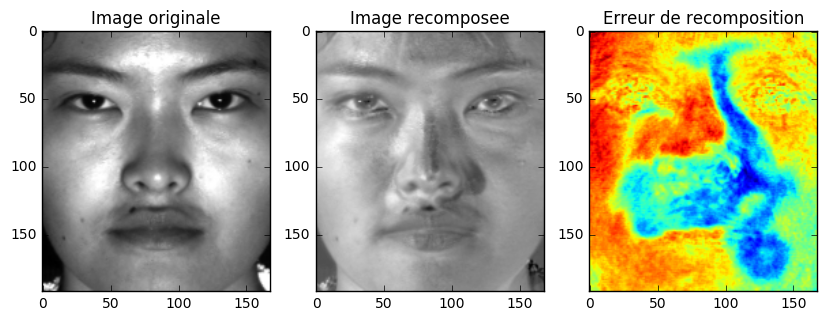

In [76]:
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[i_original], cmap='gray')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(face_recomposee, cmap='gray')
plt.title('Image recomposee')
plt.subplot(1,3,3)
plt.imshow(erreur_recomposition)
plt.title('Erreur de recomposition')

On remarque beaucoup d'erreurs !